In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import numpy as np 
import pickle
import glob 
import os 
import time , sys
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator
from cycler import cycler
from mpl_toolkits.mplot3d import Axes3D
#look at fixing later 
import warnings
warnings.filterwarnings('ignore')


data_dir='/home/ben/Documents/Bonn-uni/internship/takeaway_data/' #'/users/bhastings/internship/data/MW/' # #
metallicity='mw'
file_ext= '.dat2'

def read_dat2file(f):
    """ imports a dat22 file into pandas dataframe. f is full path to file """
    model_name= f.split('/')[-1].rsplit('.',1)[0]
    wanted_cols=['1:t[s]', '2:M/Msun', '3:Teff[K]', '4:log(L/Lsun)','5:R/Rsun','6:log(Mdot)[Msun/yr]',
                 '8:v_crit[km/s]', '9:v_surf[km/s]', '11:H','12:He','26:H_massfr', '27:He_massfr']

    if "-0" in str(f): # if file is for NON rotating star, remove vrot and crit vel from col names 
            col_names= ['1:t[s]', '2:M/Msun', '3:Teff[K]', '4:log(L/Lsun)', '5:R/Rsun', '6:log(Mdot)[Msun/yr]', '7:logg[cgs]', 
                        '10:P[days]', '11:H', '12:He', '13:Li', '14:Be', '15:B', '16:C', '17:N', '18:O', 
                    '19:F', '20:Ne', '21:Na', '22:Mg', '23:Al', '24:Si', '25:Fe', '26:H_massfr', '27:He_massfr']
    else: 
        col_names= ['1:t[s]', '2:M/Msun', '3:Teff[K]', '4:log(L/Lsun)', '5:R/Rsun', '6:log(Mdot)[Msun/yr]', '7:logg[cgs]', '8:v_crit[km/s]', 
                '9:v_surf[km/s]', '10:P[days]', '11:H', '12:He', '13:Li', '14:Be', '15:B', '16:C', '17:N', '18:O', 
                '19:F', '20:Ne', '21:Na', '22:Mg', '23:Al', '24:Si', '25:Fe', '26:H_massfr', '27:He_massfr']
     
    df= pd.read_csv(f, delim_whitespace=True,comment='#', names=col_names)#, usecols=wanted_cols)    
    
    if "-0" in str(f): # for non-rotating star, add 0 vsurf and vcrit columns 
        df['8:v_crit[km/s]'] =0       
        df['9:v_surf[km/s]'] =0 
    
    return df, model_name


def read_cen1file(f):
    """ imports a cen1 file into pandas dataframe. f is full path to file.
    also converts from abundances to mass fractions a--> f by f=10**-a"""
    
    
    #some files have scientific notation with D instead of E. Eg 1E32 is written as 1D32
    #code below fixes this with converters in read_csv
    def D_to_E(s):
        if s.isdigit():
            return s #np.float(s.replace('D', 'E'))

        else:
            return s.replace('D', 'E')
    
    
    model_name= f.split('/')[-1].rsplit('.',1)[0]
    f= str(f.split('.')[0]) +'.'+  str(f.split('.')[1]) + '.cen1'
    #print f
    col_names= ['1:?','2:t[s]',  '3:H1', '4:H2', '5:He3', '6:He4', '7:Li6', '8:Li7', 
                '9:Be7', '10:Be9', '11:B8', '12:B10', '13:B11', '14:C11', '15:C12', '16:C12', '17:N12', '18:N14', 
                '19:N15', '20:O16', '21:O17', '22:O18', '23:Ne20', '24:Ne21', '25:Ne22', '26:Na23', '27:Mg24',
                '28:Mg25', '29:Mg26', '30:Al27', '31:Si28', '32:Si29', '33:Si30', '34: Fe56', '35:F19', '36:Al26']
     
    df= pd.read_csv(f, delim_whitespace=True,comment='#', names=col_names, 
                    converters={1:D_to_E,2:D_to_E,3:D_to_E,5:D_to_E})#, usecols=wanted_cols)    
    df = df.apply(pd.to_numeric, errors='coerce', axis=1) # convert all values to floats
    times=df['2:t[s]']
    df=df.drop(['2:t[s]','1:?' ], axis=1)
    #df=np.power(10, df)
    
    #do 10**-x of all values to get mass frac
    df=-df
    df=df.rpow(10)
    df['2:t[s]']= times #add times again 
    return df, model_name




def MS_finder(f):
    #find terminal age MS time with criteria X_H > 1e-3
    df_cen, _= read_cen1file(f)
    TAMS_t= (df_cen['2:t[s]'][df_cen['3:H1'] > 5e-2].max())
    #print TAMS_t
    
    #plt.plot(df_cen['2:t[s]'],df_cen['3:H1'])
    #plt.show()
    
    #load data and filter out only rows younger than TAMS
    df, _= read_dat2file(f)
    
    df=df[df['1:t[s]'] < TAMS_t]
    
    return df, TAMS_t


def integrate_vdist(lower, upper, v_dist, v_max_val):
    """"integrates a polynomial object v_dist between lower and upper 
    v_max_val is largest v value for v_dist """
    # vdistribution as found earlier in polynomial form
    #v_dist=np.poly1d([ 4.96085349e-13, -4.27023037e-10,  6.65435944e-08,  6.46442910e-06
    #,1.93953157e-03])
    # max value of v that polynomial takes. for values greater than v, pdf is 0 
    #v_max_val=430
    
    if lower  > v_max_val:
        return 0
    
    if upper > v_max_val:
        upper= v_max_val
        
    int_func=np.polyint(v_dist)
     
    return int_func(upper) -int_func(lower)



def integrate_imf(lower, upper, alpha, eta0):
    """integrates initial mass function from power law imf with power -alpha, constant eta0.
    m is input masses. integral of imf"""
    a= -alpha +1
    
    if lower == 0 :
        
        return -(eta0 /a * upper**a)
    
    
    else:
        int_upper=  (eta0/ a) * upper**a
        int_lower= (eta0/ a) *lower**a
        integ_result= int_upper - int_lower
    
        return integ_result
    
    
def MS_finder2(f):
    #find terminal age MS time with criteria X_H > 1e-3
    df, nam= read_dat2file(f)
    
    #FIND MS MODELS. based on when the star's radius first starts to shrink.
    ##########################################################################
    y=np.array(df['5:R/Rsun'])
    t=np.array(df['1:t[s]'])
    dydt= np.gradient(y, t)
    u=lambda x : x< -1e-6
        
    #if model leaves ms...
    if np.unique(u(dydt), return_counts=True)[1][0] !=len(dydt):
            index=np.nonzero(dydt ==(filter(u, dydt)[0]))[0].min()
            t_endMS= t[index]
            df=df[df['1:t[s]'] < float(t_endMS)] 
            #plt.plot(df['1:t[s]'], df['9:v_surf[km/s]']/df['8:v_crit[km/s]'])
            #plt.title(nam)
            #plt.show()
            return df, t_endMS
    else:
        return df, None

In [337]:
# sort file names so that they are listed by mass, then rotation velocity 
m_val=lambda x : int(x.split('/')[-1].split('.')[0].split('-')[0][1:])
v_val= lambda x : int(x.split('/')[-1].split('.')[0].split('-')[1])

s1=sorted(glob.glob(data_dir +'*'+ file_ext), key=v_val)
data_files=sorted(s1, key= m_val)


#cut stars heavier than 40M, at they do not contribute to Be
data_files=filter(lambda x: m_val(x) < 40, data_files)
#print data_files

mass_list=[]
for f in data_files:
    mass_list=np.append(mass_list, int(m_val(f)))
    
mass_list=np.unique(mass_list)


print 'masses of models :\n',mass_list
print mass_list[0:7]

masses of models :
[ 3.  5.  7.  9. 10. 12. 15. 20. 25. 30. 35.]
[ 3.  5.  7.  9. 10. 12. 15.]


In [8]:
v_dist=np.poly1d([ 4.96085349e-13, -4.27023037e-10,  6.65435944e-08,  6.46442910e-06
  ,1.93953157e-03])
v_max_val=430

In [323]:
#check that total CDF between mass limits is 1. If not eta0 value needs to be tweaked! 

alpha=2.3
eta0=1 / integrate_imf(3,12, alpha,1)
lower= 3
upper =12

print "integral of IMF between ", lower,'and', upper, ',eta0 = ', eta0, ":"
print integrate_imf(lower, upper, alpha,eta0)

integral of IMF between  3 and 12 ,eta0 =  6.49355489602 :
1.0


In [343]:
Be_value=0.7 # minimum v/vcrit value required for Be stars 


t_end=20e6 # end time in Myr
n_vals=10
m_vals=mass_list[0:7]

start_time = time.time()
print "STARTING"
i=0
i2=0

for t in [80e6]:#np.linspace(0, t_end, n_vals):
    
    resdf1=pd.DataFrame(columns=['f-name','M','t','t_i', 'V', 'T_MS', 'V/Vcrit', 't_i/T_MS'])
   
    
    i=0
    i2=i2+1

    for m in m_vals:
        m_group_files = filter(lambda x : m_val(x)==m, data_files)
        
        for fil in m_group_files:
            f_name=str(m_val(fil)) + '-'+ str(v_val(fil))
            #print message
            message="working on file " +str(i) + " / "+ str(len(data_files)) + " :time loop "+str(i2) + " / "+ str(n_vals)
            sys.stdout.write ('\r'+ message)
            i=i+1
            
            #load in data and find points on the MS
            df_ms, T_ms= MS_finder2(fil)
            
            # if star is still alive...
            
            # index of time closest to t 
            T_indx=(df_ms['1:t[s]']-t).abs().argmin()
            t_i=df_ms['1:t[s]'].loc[T_indx]
            V= df_ms['9:v_surf[km/s]'].loc[T_indx] 
            #if star is rotating 
            if v_val(fil) != 0:
                V_over_Vcrit=V/ df_ms['8:v_crit[km/s]'].loc[T_indx]
                
            else:
                V_over_Vcrit=0
            ti_over_tms=t/T_ms
                

            resdf1=resdf1.append(pd.DataFrame([[f_name,m,t,t_i ,V, T_ms,V_over_Vcrit, ti_over_tms]],
                                                  columns=['f-name','M','t','t_i', 'V', 'T_MS', 'V/Vcrit', 't_i/T_MS']))
    
    resdf1.reset_index(drop=True, inplace=True)

    
    
    r_array=[]

    n_inter=1e2
    #print eta0, alpha
    for u in range (0, int(n_inter)):
        message=str(u) + " / "+ str(int(n_inter)) 
        sys.stdout.write ('\r'+ message)



        rand_m, p_dict =random_M_value(resdf1, alpha, eta0)

        V_min =V_min_calc(rand_m, resdf1)

        #integral over vdist from v_min(M) to v_max 
        i2=integrate_vdist(V_min,v_max_val,  v_dist,v_max_val)

        M_max = M_max_calc(resdf1, v_max_val)
        M_min= df['M'].unique().min() # lowest M value in  result dataframe

        i1= integrate_imf(M_min, M_max, alpha, 1)

        #print "M value =", rand_m , ': p(M)=',  np.round(p_dict[rand_m], 4), ': V_min=',  V_min, ': M_max=', M_max

        r= i1 *i2 / p_dict[rand_m]
        r_array=np.append(r_array, r)

    print '########'
    print 'time', t/1e6 , 'frac stars: ', r_array.mean()
#resdf1.head(100)
print 'FINISHED'
#print resdf1.to_string()

STARTING
0 / 100M value = 5.0 : p(M)= 0.357 : V_min= 0 : M_max= 5.558547780383154
1 / 100M value = 5.0 : p(M)= 0.357 : V_min= 0 : M_max= 5.558547780383154
2 / 100M value = 5.0 : p(M)= 0.357 : V_min= 0 : M_max= 5.558547780383154
3 / 100M value = 5.0 : p(M)= 0.357 : V_min= 0 : M_max= 5.558547780383154
4 / 100M value = 3.0 : p(M)= 0.643 : V_min= 0 : M_max= 5.558547780383154
5 / 100M value = 5.0 : p(M)= 0.357 : V_min= 0 : M_max= 5.558547780383154
6 / 100M value = 3.0 : p(M)= 0.643 : V_min= 0 : M_max= 5.558547780383154
7 / 100M value = 5.0 : p(M)= 0.357 : V_min= 0 : M_max= 5.558547780383154
8 / 100M value = 3.0 : p(M)= 0.643 : V_min= 0 : M_max= 5.558547780383154
9 / 100M value = 5.0 : p(M)= 0.357 : V_min= 0 : M_max= 5.558547780383154
10 / 100M value = 3.0 : p(M)= 0.643 : V_min= 0 : M_max= 5.558547780383154
11 / 100M value = 3.0 : p(M)= 0.643 : V_min= 0 : M_max= 5.558547780383154
12 / 100M value = 3.0 : p(M)= 0.643 : V_min= 0 : M_max= 5.558547780383154
13 / 100M value = 5.0 : p(M)= 0.357 : V

In [334]:
print resdf1.to_string()

    f-name     M           t         t_i           V         T_MS   V/Vcrit  t_i/T_MS
0      3-0   3.0  20000000.0  20272300.0    0.000000  325401000.0  0.000000  0.061463
1     3-50   3.0  20000000.0  20015100.0   58.797863  326288000.0  0.107189  0.061296
2    3-100   3.0  20000000.0  19942900.0  118.131502  327724000.0  0.216136  0.061027
3    3-150   3.0  20000000.0  20428400.0  177.067662  332572000.0  0.326708  0.060137
4    3-200   3.0  20000000.0  20631700.0  236.811505  333782000.0  0.442912  0.059919
5    3-250   3.0  20000000.0  19671000.0  299.117665  337702000.0  0.567070  0.059224
6    3-300   3.0  20000000.0  20505900.0  362.178138  341010000.0  0.704837  0.058649
7    3-350   3.0  20000000.0  19582500.0  421.286271  349853000.0  0.833474  0.057167
8    3-400   3.0  20000000.0  20399400.0  447.667267  354912000.0  0.919395  0.056352
9    3-420   3.0  20000000.0  19883700.0  486.271281  386734000.0  0.995813  0.051715
10   3-450   3.0  20000000.0  20558600.0  491.046433  

In [340]:
r_array=[]

n_inter=1e2
print eta0, alpha
for u in range (0, int(n_inter)):
    message=str(u) + " / "+ str(int(n_inter)) 
    sys.stdout.write ('\r'+ message)
 
    
    
    rand_m, p_dict =random_M_value(resdf1, alpha, eta0)
    #rand_m =12
    V_min =V_min_calc(rand_m, resdf1)

    #integral over vdist from v_min(M) to v_max 
    i2=integrate_vdist(V_min,v_max_val,  v_dist,v_max_val)

    M_max = M_max_calc(resdf1, v_max_val)
    M_min= df['M'].unique().min() # lowest M value in  result dataframe

    i1= integrate_imf(M_min, M_max, alpha, 1)

    #print "M value =", rand_m , ': p(M)=',  np.round(p_dict[rand_m], 4), ': V_min=',  V_min, ': M_min=', M_min

    r= i1 *i2 / p_dict[rand_m]
    r_array=np.append(r_array, r)
    
print '########'
print r_array.mean()



6.49355489602 2.3
99 / 100########
0.6992938169474694


In [158]:
print resdf1.to_string()

   f-name     M           t         t_i           V         T_MS   V/Vcrit  t_i/T_MS
0     3-0   3.0  17000000.0  16433200.0    0.000000  325401000.0  0.000000  0.052243
0    3-50   3.0  17000000.0  16209700.0   58.918784  326288000.0  0.107000  0.052101
0   3-100   3.0  17000000.0  16150800.0  118.344973  327724000.0  0.215719  0.051873
0   3-150   3.0  17000000.0  16550800.0  177.406849  332572000.0  0.326051  0.051117
0   3-200   3.0  17000000.0  16728800.0  237.218483  333782000.0  0.441928  0.050931
0   3-250   3.0  17000000.0  17649800.0  299.277314  337702000.0  0.566264  0.050340
0   3-300   3.0  17000000.0  16312400.0  362.357553  341010000.0  0.702569  0.049852
0   3-350   3.0  17000000.0  17032600.0  420.825744  349853000.0  0.831515  0.048592
0   3-400   3.0  17000000.0  17301300.0  445.775107  354912000.0  0.913397  0.047899
0   3-420   3.0  17000000.0  14731400.0  486.589414  386734000.0  0.994592  0.043958
0   3-450   3.0  17000000.0  15171000.0  490.904852  390941000.0 

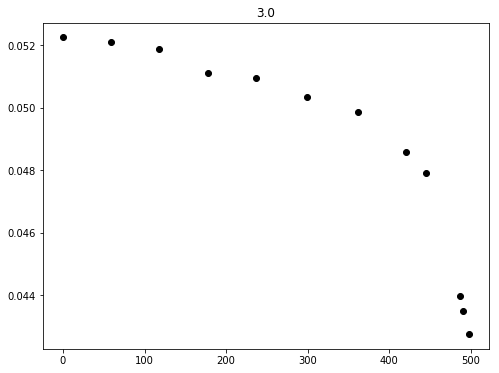

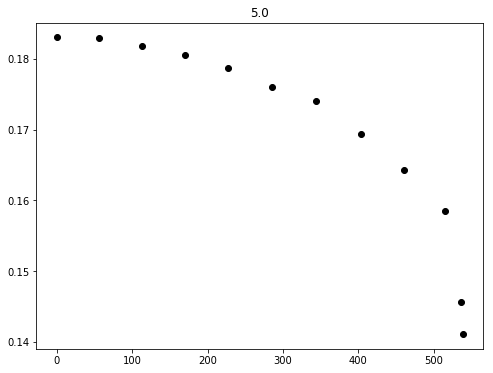

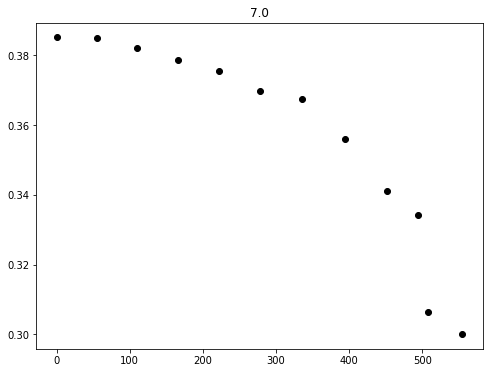

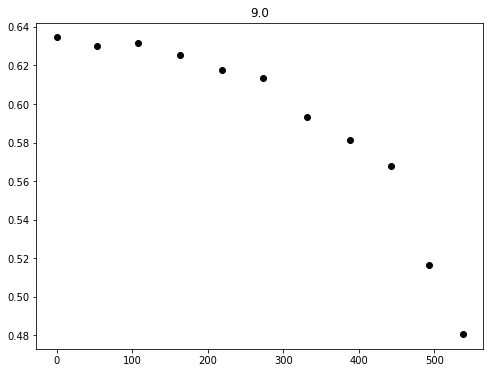

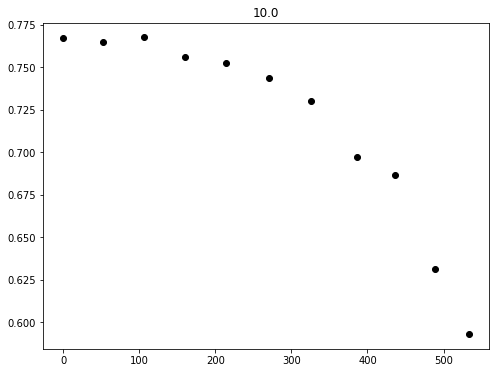

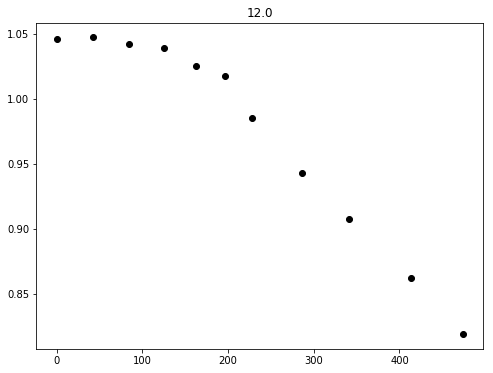

In [24]:
mass_groups= resdf1.groupby('M')
resdf2=pd.DataFrame(columns=['M','t', 'V_min', 'Tstar_MS', 'V/Vcrit_min'])
for m,mass_group in mass_groups:
    y=df['t_i/T_MS'][(df.M==M)]
    x=mass_group['V']
    
    plt.plot(x,y,'ko')
    plt.title(m)
    plt.show()

In [338]:


#print resdf1.to_string()

def random_M_value(df, alpha, eta0):
    ##################################
    # PERHAPS WRONG TO FILTER OUT ONLY MS STARS????
    ######################
    M_vals=np.unique(df['M'][df['t_i/T_MS'] <1.0])
    
    #add first mass manually 
    mass_bins=pd.DataFrame([[M_vals[0], M_vals[0],( -M_vals[0]+ M_vals[1])*0.5 + M_vals[0] ]],
                           columns=['M', 'lower_bin', 'upper_bin'])
    
    for i in range(1,len(M_vals)-1):
        l=( -M_vals[i]+ M_vals[i-1])*0.5 + M_vals[i]
        u= ( -M_vals[i]+ M_vals[i+1])*0.5 + M_vals[i]
        #print M_vals[i],'lower',( -M_vals[i]+ M_vals[i-1])*0.5 + M_vals[i],
        #print 'upper',( -M_vals[i]+ M_vals[i+1])*0.5 + M_vals[i]
        mass_bins=mass_bins.append(pd.DataFrame([[M_vals[i], l,u]],columns=['M', 'lower_bin', 'upper_bin'] ))
     
    # add last mass manually 
    l=( -M_vals[-2]+ M_vals[-1])*0.5 + M_vals[-2]
    u=  M_vals[-1]
    mass_bins=mass_bins.append(pd.DataFrame([[M_vals[-1], l,u]],columns=['M', 'lower_bin', 'upper_bin'] ))
    
    #do integration on IMF over bins
    p = lambda x : integrate_imf(x.lower_bin, x.upper_bin, alpha, eta0 )
    mass_bins['p']= mass_bins.apply(p, axis=1)
    
    #print mass_bins
    #print mass_bins['p'].sum()
    p_vals=mass_bins['p']/mass_bins['p'].sum()
    random_m_val= np.random.choice(mass_bins['M'], p=p_vals)# p normalised to sum of probs to avoid sum !=1 error
    return random_m_val, dict(zip(M_vals, p_vals))
    



def M_max_calc(df, v_max_value):
    
    #if non-rotating maximum mass star is still on MS, retun maximum mass star mass
    if df['t_i/T_MS'][(df.M == df['M'].max()) & (df.V == 0)].values[0] < 1.0 :
        return df['M'].max()
    
    
    # x is t/t_ms, y is V
    grid_x, grid_y = np.mgrid[0.5:1:1000j, 0: v_max_value:1000j]
    values = np.array(resdf1['M'].astype(float))
    points=np.array(resdf1[['t_i/T_MS','V' ]])


    grid_z0 = griddata(points, values, (grid_x, grid_y), method='linear')

    #print grid_y[0][950]
    #print grid_x[900][0]

    M_min_candidates=[]
    for x in range(900,1000-1):
        for y in range(900,1000-1):
            M_min_candidates=np.append(M_min_candidates,grid_z0[x][y])

    #plot interpolation
    #plt.imshow(grid_z0, extent=(0.9,1,0.9,1), origin='lower')
    #plt.colorbar()
    #plt.show()
    
    M_min= np.nanmean( M_min_candidates)
    return M_min


def V_min_calc(M, df):
    # fractional age of non-rotating model
    non_rot_tovertms= df['t_i/T_MS'][(df.M==M) & (df.V==0)].values
    #print non_rot_tovertms
    #if non rotating model is NOT MS
    if non_rot_tovertms > 1.0:
        # find 2 points eitherside of 1.0 and then linearly interpolate to get V_min 
        y=df['t_i/T_MS'][(df.M==M)]
        x=df['V'][(df.M==M)]
        
        #print df[(df.M==M)]
        #y.reset_index(drop=True, inplace=True)
        #print y[(y-1).abs().argmin()] , x[(y-1).abs().argmin()]
        #print y[(-y+1).argmin()] , x[(-y+1).argmin()]
        
        # get indexes of points with t/Tms straddling t/Tms =1 
        p_1_indx=df['t_i/T_MS'][(df.M==M) & (df['t_i/T_MS'] >1)].argmin()
        m_1_index=df['t_i/T_MS'][(df.M==M) & (df['t_i/T_MS'] <1)].argmax()
        
        #print  y[df['t_i/T_MS'][(df.M==M) & (df['t_i/T_MS'] >1)].argmin()]#(y-1)#.abs()#.argmin()
        #print 'XXXXX'
        #print  y[df['t_i/T_MS'][(df.M==M) & (df['t_i/T_MS'] <1)].argmax()]#(y-1)#.abs()#.argmin()
        
        
        #interpolate between two previously found points to find V at t/Tms=1 
        straight_line=np.poly1d(np.polyfit( [y[p_1_indx], y[m_1_index]],
                                            [x[p_1_indx], x[m_1_index]],
                                            1))
        
       
        #plot to check results 
        #plt.axhline( y[p_1_indx])
        #plt.axhline(y[m_1_index])
        #plt.plot(x,y,'ko')
        #plt.plot(straight_line(1.0), 1, 'go')
        #plt.show()
        
        V_min =straight_line(1.0)
        
        return V_min
    
    
    #if non rotating model is on MS
    else:
        return 0
    
    
print V_min_calc(12, resdf1)

256.0067098666883


In [326]:
print random_M_value(resdf1, alpha, eta0)

df=resdf1
print df['M'].max()
print  df['t_i/T_MS'][(df.M == df['M'].max()) & (df.V == 0)].values
print M_max_calc(resdf1, v_max_val)

(5.0, {3.0: 0.37364185733724525, 5.0: 0.3375318632688247, 7.0: 0.15174574700058605, 9.0: 0.06698948551227042, 10.0: 0.046436370522118915, 12.0: 0.02365467635895472})
15.0
[0.]
15.0


In [ ]:
    #print ' '
    #print resdf1.dropna().to_string()
    
    #########################################
    # interpolate values                    #
    #########################################
    #M_max   
    ########################################
    resdf1=resdf1.dropna()
    grid_x, grid_y = np.mgrid[0.5:1:100j, 0.5:1:200j]
    values = np.array(resdf1['M'].astype(float))

    points=np.array(resdf1[['t_i/T_MS','V/Vcrit' ]])

    from scipy.interpolate import griddata
    grid_z0 = griddata(points, values, (grid_x, grid_y), method='cubic')

    #plt.imshow(grid_z0, extent=(0.9,1,0.9,1), origin='lower')

    Max_m= 0
    for x in range(0, len(grid_x)):
            for y in range(0, len(grid_y)):
                if grid_z0[x][y] > Max_m:
                    Max_m= grid_z0[x][y]

    #print ' '
    print Max_m , t/1e6

    #v_min
    ##################################################
    
    resdf1=resdf1.dropna()
    x=np.array(resdf1['t_i/T_MS'])#[-20:]
    y=np.array(resdf1['M'])#[-20:]
    z=np.array(resdf1['V'])#[-20:]

    #print x,y,z
    f = interpolate.interp2d(x, y, z, kind='linear')

    m_list=np.linspace(3,12,500)
    for i in m_list:
        plt.plot(i, f(0.9,i), 'k.' )
    
    
    #plt.ylim(-1e5,1e4)
    plt.axhline(0)
    plt.axvline(Max_m)
    plt.title(str(m) +'Msun-'+ str(t/1e6) +'Myr')
    plt.ylabel('V at t=T_ms')
    plt.show()